In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import urllib
import json
import psycopg2

import pymongo
from pymongo import MongoClient, InsertOne

#Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

## loading data from url and connecting it with mongodb

In [2]:
import requests
from pymongo import MongoClient

# Define the URL for the JSON data
url = 'https://data.cityofnewyork.us/resource/f55k-p6yu.json'

# Make a GET request to the URL and store the JSON response
response = requests.get(url)
json_data = response.json()

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')

# Select the database and collection where you want to store the data
db = client['my_database']
collection = db['my_collection']

# Insert the JSON data into the collection
collection.insert_many(json_data)

In [3]:
#pipeline 

In [4]:
import luigi
import pymongo
import pandas as pd

class LoadFromMongodb(luigi.Task):
    """
    A Luigi task to write data from a mongodb collection to a CSV file.
    """
    client = luigi.Parameter()
    database = luigi.Parameter()
    collection = luigi.Parameter()
    output_path = luigi.Parameter()

    def output(self):
        """
        Returns the target output for this task. 

        """
        return luigi.LocalTarget(self.output_path)

    def run(self):
        """
        Contains the logic of the Task, 
        """
        # setting mongodb client
        client = pymongo.MongoClient(self.client)
        db = client[self.database]
        collection = db[self.collection]
        
        # load data from mongo db and save into dataframe
        loaded_data = collection.find()
        df = pd.DataFrame(loaded_data)
        df.drop(['_id'], axis=1, inplace=True)
        
        # write data to output file
        with self.output().open("w") as f:
            f.write(df.to_csv(index=False))

class ProcessData(luigi.Task):
    """
    A Luigi task to process data from a CSV file.
    """
    input_path = luigi.Parameter()
    output_path = luigi.Parameter()

    def requires(self):
        """
        Returns the tasks that this task depends on.
        """
        return LoadFromMongodb(client="mongodb://localhost:27017",
                               database="my_database",
                               collection="my_collection",
                               output_path=self.input_path)

    def output(self):
        """
        Returns the target output for this task.
        """
        return luigi.LocalTarget(self.output_path)

    def run(self):
        """
        Contains the logic of the Task.
        """
        # load data from input file
        df = pd.read_csv(self.input_path)
        
        # process data
        processed_data = df.groupby('some_column').sum()
        
        # write processed data to output file
        with self.output().open("w") as f:
            f.write(processed_data.to_csv(index=False))

In [5]:
# create a class to run luigi task and run the pipeline 
class LoadFromMongodb(luigi.Task):
    """
    A Luigi task to write a json file into mongodb
    """
    client = luigi.Parameter()
    database = luigi.Parameter()
    collection = luigi.Parameter()
    path = luigi.Parameter()

    def output(self):
        """
        Returns the target output for this task. 

        """
        return luigi.LocalTarget(self.path)

    def run(self):
        """
        Contains the logic of the Task, 
        """
        # setting mongodb client
        client = pymongo.MongoClient(self.client)
        db = client[self.database]
        collection = db[self.collection]
        
        # load data from mongo db and save into dataframe
        loaded_data = collection.find()
        df = pd.DataFrame(loaded_data)
        df.drop(['_id'], axis = 1, inplace = True)
        with self.output().open("w") as f:
            f.write(df.to_csv(index = False))

In [6]:
luigi.build([LoadFromMongodb(client="mongodb://localhost:27017", database="my_database", collection = "my_collection",
                             path = "Person_loaded_data.csv")], workers=1, local_scheduler=True)

DEBUG: Checking if LoadFromMongodb(client=mongodb://localhost:27017, database=my_database, collection=my_collection, path=Person_loaded_data.csv) is complete
INFO: Informed scheduler that task   LoadFromMongodb_mongodb___localh_my_collection_my_database_c6535ce851   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=5043547425, workers=1, host=DESKTOP-IDRROBP, username=LENOVO, pid=5420) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 LoadFromMongodb(client=mongodb://localhost:27017, database=my_database, collection=my_collection, path=Person_loaded_data.csv)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



True

In [7]:
df= pd.read_csv("Person_loaded_data.csv")

## checking profile of data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unique_id              1000 non-null   int64  
 1   collision_id           1000 non-null   int64  
 2   crash_date             1000 non-null   object 
 3   crash_time             1000 non-null   object 
 4   person_id              1000 non-null   object 
 5   person_type            1000 non-null   object 
 6   person_injury          1000 non-null   object 
 7   vehicle_id             945 non-null    float64
 8   ped_role               1000 non-null   object 
 9   person_sex             902 non-null    object 
 10  person_age             777 non-null    float64
 11  ejection               504 non-null    object 
 12  emotional_status       517 non-null    object 
 13  bodily_injury          517 non-null    object 
 14  position_in_vehicle    505 non-null    object 
 15  safet

## converting to csv

In [9]:
import requests
import csv

# Define the URL for the JSON data
url = 'https://data.cityofnewyork.us/resource/f55k-p6yu.json'

# Make a GET request to the URL and store the JSON response
response = requests.get(url)
json_data = response.json()

# Define the output CSV filename
output_file = 'output.csv'

# Write the JSON data to the CSV file
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write the header row
    header = list(json_data[0].keys())
    writer.writerow(header)
    
    # Write the data rows
    for row in json_data:
        writer.writerow(row.values())

## calling the csv

In [10]:
import csv

# Define the input CSV filename
input_file = 'output.csv'

# Read the CSV file
with open(input_file, 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    
    # Print the rows to the console
    for row in reader:
        print(row)

['unique_id', 'collision_id', 'crash_date', 'crash_time', 'person_id', 'person_type', 'person_injury', 'vehicle_id', 'ped_role', 'person_sex']
['10249006', '4229554', '2019-10-26T00:00:00.000', '9:43', '31aa2bc0-f545-444f-8cdb-f1cb5cf00b89', 'Occupant', 'Unspecified', '19141108', 'Registrant', 'U']
['10255054', '4230587', '2019-10-25T00:00:00.000', '15:15', '4629e500-a73e-48dc-b8fb-53124d124b80', 'Occupant', 'Unspecified', '19144075', '33', 'Not Ejected', 'Does Not Apply', 'Does Not Apply', 'Front passenger, if two or more persons, including the driver, are in the front seat', 'Lap Belt & Harness', 'Does Not Apply', 'Passenger', 'F']
['10253177', '4230550', '2019-10-26T00:00:00.000', '17:55', 'ae48c136-1383-45db-83f4-2a5eecfb7cff', 'Occupant', 'Unspecified', '19143133', '55', 'Registrant', 'M']
['6650180', '3565527', '2016-11-21T00:00:00.000', '13:05', '2782525', 'Occupant', 'Unspecified', 'Notified Person']
['10255516', '4231168', '2019-10-25T00:00:00.000', '11:16', 'e038e18f-40fb-447

In [11]:
#

In [12]:
with open('output.csv', 'r') as f:
    for i, line in enumerate(f):
        num_fields = len(line.strip().split(','))
        print(f"Line {i+1} has {num_fields} fields")

Line 1 has 10 fields
Line 2 has 10 fields
Line 3 has 20 fields
Line 4 has 11 fields
Line 5 has 8 fields
Line 6 has 17 fields
Line 7 has 17 fields
Line 8 has 11 fields
Line 9 has 17 fields
Line 10 has 17 fields
Line 11 has 10 fields
Line 12 has 17 fields
Line 13 has 20 fields
Line 14 has 10 fields
Line 15 has 10 fields
Line 16 has 11 fields
Line 17 has 10 fields
Line 18 has 11 fields
Line 19 has 11 fields
Line 20 has 17 fields
Line 21 has 17 fields
Line 22 has 10 fields
Line 23 has 11 fields
Line 24 has 10 fields
Line 25 has 11 fields
Line 26 has 20 fields
Line 27 has 11 fields
Line 28 has 10 fields
Line 29 has 17 fields
Line 30 has 17 fields
Line 31 has 8 fields
Line 32 has 11 fields
Line 33 has 17 fields
Line 34 has 11 fields
Line 35 has 11 fields
Line 36 has 9 fields
Line 37 has 10 fields
Line 38 has 11 fields
Line 39 has 18 fields
Line 40 has 10 fields
Line 41 has 17 fields
Line 42 has 10 fields
Line 43 has 10 fields
Line 44 has 17 fields
Line 45 has 11 fields
Line 46 has 20 fields


# finding missing values

In [13]:
print('Total null reocrds in Data :\n',df.isnull().sum())

Total null reocrds in Data :
 unique_id                  0
collision_id               0
crash_date                 0
crash_time                 0
person_id                  0
person_type                0
person_injury              0
vehicle_id                55
ped_role                   0
person_sex                98
person_age               223
ejection                 496
emotional_status         483
bodily_injury            483
position_in_vehicle      495
safety_equipment         496
complaint                483
ped_location             987
ped_action               987
contributing_factor_1    987
contributing_factor_2    987
dtype: int64


In [14]:
# Droping the columns with missing values
df = df.dropna(axis=1)

# Print the updated DataFrame
print(df)

     unique_id  collision_id               crash_date crash_time  \
0     10249006       4229554  2019-10-26T00:00:00.000       9:43   
1     10255054       4230587  2019-10-25T00:00:00.000      15:15   
2     10253177       4230550  2019-10-26T00:00:00.000      17:55   
3      6650180       3565527  2016-11-21T00:00:00.000      13:05   
4     10255516       4231168  2019-10-25T00:00:00.000      11:16   
..         ...           ...                      ...        ...   
995   10250224       4230220  2019-10-26T00:00:00.000      15:28   
996   10250430       4230166  2019-10-26T00:00:00.000      20:30   
997   10253910       4231002  2019-10-24T00:00:00.000      12:35   
998   10248402       4229633  2019-10-26T00:00:00.000      12:30   
999   10250616       4230210  2019-10-26T00:00:00.000      22:02   

                                person_id person_type person_injury  \
0    31aa2bc0-f545-444f-8cdb-f1cb5cf00b89    Occupant   Unspecified   
1    4629e500-a73e-48dc-b8fb-53124d124b80

In [15]:
#to find the number of columns and rows
df.shape

(1000, 8)

In [16]:
# As we have huge amount of data we can drop duplicate values too
df.drop_duplicates(inplace = True)

In [17]:
#to find the column names
print(df.columns)

Index(['unique_id', 'collision_id', 'crash_date', 'crash_time', 'person_id',
       'person_type', 'person_injury', 'ped_role'],
      dtype='object')


In [18]:
# Finding the invalid data
invalid_data = df[~df.astype(str).apply(lambda x: x.str.isnumeric()).all(axis=1)]

# Printing the invalid data
print(invalid_data)

     unique_id  collision_id               crash_date crash_time  \
0     10249006       4229554  2019-10-26T00:00:00.000       9:43   
1     10255054       4230587  2019-10-25T00:00:00.000      15:15   
2     10253177       4230550  2019-10-26T00:00:00.000      17:55   
3      6650180       3565527  2016-11-21T00:00:00.000      13:05   
4     10255516       4231168  2019-10-25T00:00:00.000      11:16   
..         ...           ...                      ...        ...   
995   10250224       4230220  2019-10-26T00:00:00.000      15:28   
996   10250430       4230166  2019-10-26T00:00:00.000      20:30   
997   10253910       4231002  2019-10-24T00:00:00.000      12:35   
998   10248402       4229633  2019-10-26T00:00:00.000      12:30   
999   10250616       4230210  2019-10-26T00:00:00.000      22:02   

                                person_id person_type person_injury  \
0    31aa2bc0-f545-444f-8cdb-f1cb5cf00b89    Occupant   Unspecified   
1    4629e500-a73e-48dc-b8fb-53124d124b80

Most incidents involve people between the ages of 20 and 60.

## Data analysis


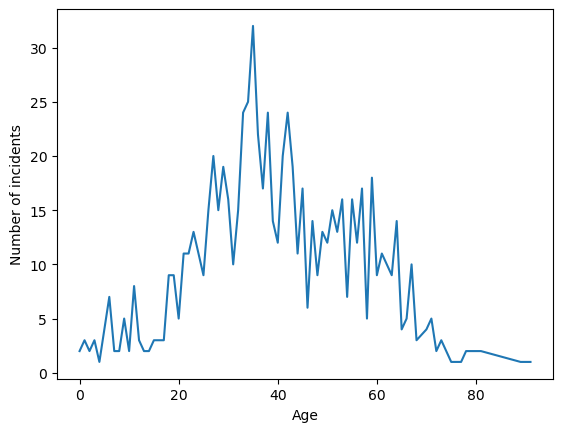

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Fetch the data from the API
url = 'https://data.cityofnewyork.us/resource/f55k-p6yu.json'
response = requests.get(url)
data = response.json()
# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data)

# Convert the person_age column to numeric format
df['person_age'] = pd.to_numeric(df['person_age'], errors='coerce')

# Group the data by person_age and count the number of incidents
df_daily = df.groupby('person_age').size().reset_index(name='count')

# Plot the data as a line graph
plt.plot(df_daily['person_age'], df_daily['count'])
plt.xlabel('Age')
plt.ylabel('Number of incidents')
plt.show()


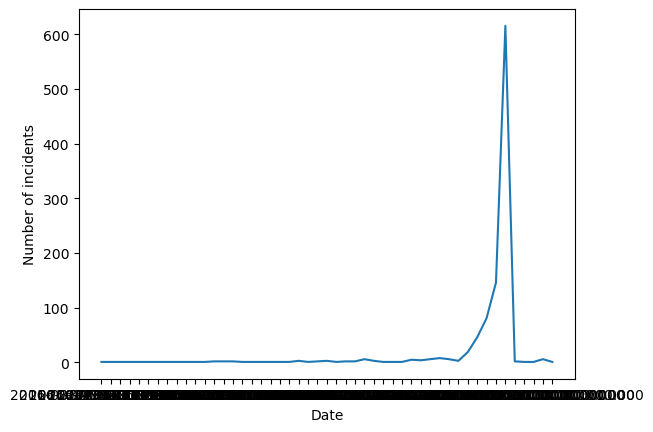

In [21]:
df['date'] = pd.to_datetime(df['crash_date'])
df_daily = df.groupby('crash_date').size().reset_index(name='count')

plt.plot(df_daily['crash_date'], df_daily['count'])
plt.xlabel('Date')
plt.ylabel('Number of incidents')
plt.show()

Incidences are at their highest during the most recent dates.

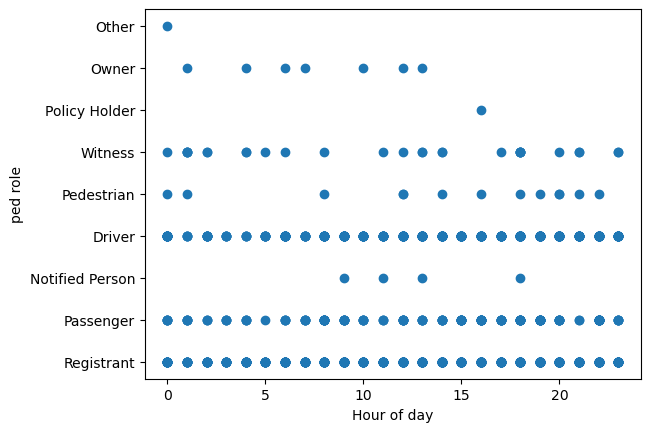

In [22]:
import requests
import matplotlib.pyplot as plt
from datetime import datetime

# Make a GET request to the API endpoint
url = "https://data.cityofnewyork.us/resource/f55k-p6yu.json"
params = {"$limit": 1000}
response = requests.get(url, params=params)

# Extract the necessary data from the response
data = response.json()
x_values = [datetime.strptime(record["crash_time"], "%H:%M").hour for record in data]
y_values = [record["ped_role"] for record in data]

# Create a scatter plot
plt.scatter(x_values, y_values)
plt.xlabel("Hour of day")
plt.ylabel("ped role")
plt.show()             

According to this statistic, accidents involving drivers, passengers, and registered users happen more frequently throughout the day, almost once every hour.

ValueError: num must be 1 <= num <= 6, not 7

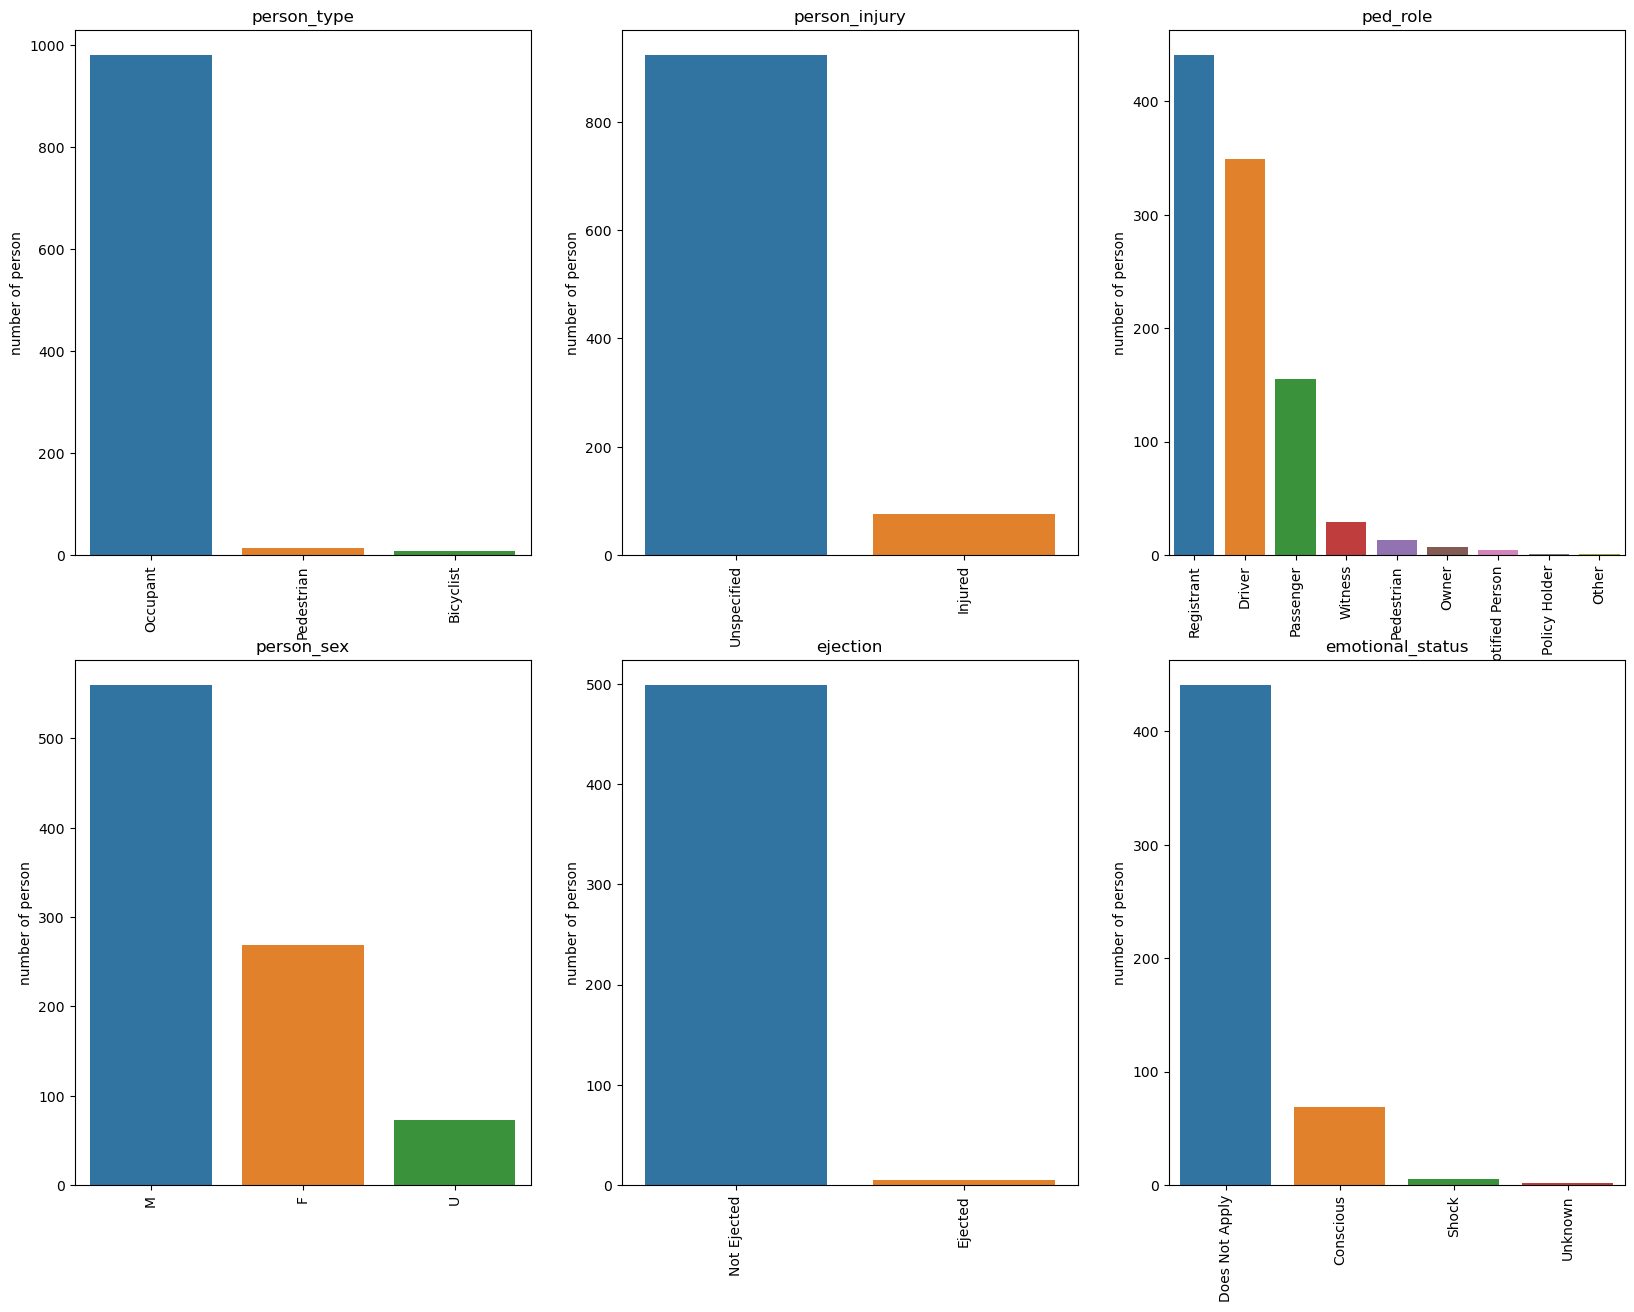

In [24]:
# plotting the data in bar graphs, numer of person is kept the same for all 
cols = [x for x in df.columns if df[x].dtype=='O']
i = 1
plt.figure(figsize=(20,15))
for col in cols[:-1] :
    plt.subplot(2,3,i)
    data = df[col].value_counts()
    if len(data.index) < 10 :
        sns.barplot(x = data.index , y = data.values)
        plt.title(col)
        plt.xlabel('')
        plt.xticks(rotation = 90)

        plt.ylabel('number of person')
        i+=1

**Report**
- Most of the individuals are occupants.
- The severity of the injuries was frequently not specified.
- Registration holders, drivers, and passengers play more in number.
- the main gender of pedestrain is male.
- most of the time there is not Ejection and in many cases it did not mentioned and was missing.
- the main gender of pedestrain is male.
- most of the people does not apply any emotions and only less than 100 of them were conscious.

## saving the cleaned data into SQL

In [25]:
#Created a server and uploading the dta into there.
conn = psycopg2.connect(database="postgres",
                        host="87.44.4.198",
                        user="data",
                        password="data",
                        port="5432")
conn.autocommit = True
cursor = conn.cursor()
# create database
query = '''CREATE database Person_db'''
try: 
    cursor.execute(query)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

database "person_db" already exists



In [26]:
import psycopg2
from sqlalchemy import create_engine

# PostgreSQL connection information
db_name = "postgres"
db_user = "data"
db_password = "data"
db_host = "87.44.4.198"
db_port = "5432"

# Creating an engine to connect to the database
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Inserting the DataFrame to a table called my_table
table_name = "person_dta"
df.to_sql(table_name, engine, if_exists='append', index=False)

1000